In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
df = data[["Close"]].copy()
df.columns = ["price"]

# Инженерия признаков
df["return_1d"] = df["price"].pct_change()
df["return_5d"] = df["price"].pct_change(5)
df["volatility_5d"] = df["return_1d"].rolling(5).std()
df["momentum_10d"] = df["price"] / df["price"].shift(10) - 1

# Целевая переменная: 1 если завтра выше, иначе 0
df["target"] = (df["price"].shift(-1) > df["price"]).astype(int)

df.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[["return_1d", "return_5d", "volatility_5d", "momentum_10d"]]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.45      0.45       235
           1       0.55      0.55      0.55       290

    accuracy                           0.50       525
   macro avg       0.50      0.50      0.50       525
weighted avg       0.51      0.50      0.50       525



In [4]:
df["predicted_signal"] = model.predict(X)
df["predicted_signal"] = df["predicted_signal"].shift(1)  # чтобы избежать lookahead bias

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


<Axes: title={'center': 'ML Strategy - Equity Curve'}>

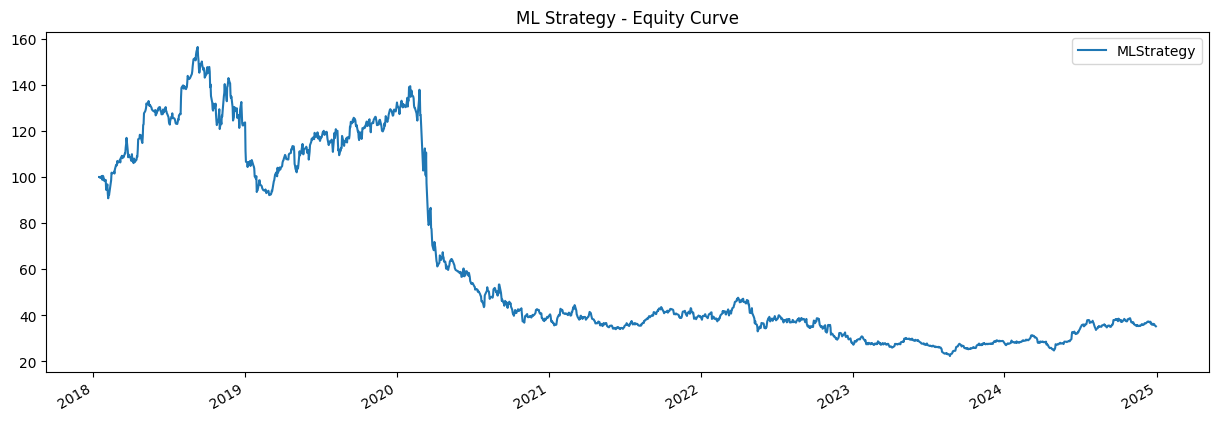

In [12]:
import bt

def run_ml_strategy(df):
    price = df[["price"]]
    signal = df[["predicted_signal"]]
    signal = signal.rename(columns={'predicted_signal':'price'})
    # Преобразуем сигнал 0/1 → -1/+1 для bt.py
    signal = signal.replace({0: -1, 1: 1})

    strategy = bt.Strategy(
        "MLStrategy",
        [
            bt.algos.RunDaily(),
            bt.algos.SelectAll(),
            bt.algos.WeighTarget(signal),
            bt.algos.Rebalance()
        ]
    )

    backtest = bt.Backtest(strategy, price)
    return bt.run(backtest)

result = run_ml_strategy(df)
result.plot(title="ML Strategy - Equity Curve")

In [13]:
stats = result[0].stats
print("Sharpe Ratio:", stats.loc["daily_sharpe"])
print("CAGR:", stats.loc["cagr"])
print("Max Drawdown:", stats.loc["max_drawdown"])

Sharpe Ratio: -0.3353152785373574
CAGR: -0.13936547757260664
Max Drawdown: -0.8574120577846777
